# 7.3 모델의 성능을 최대로 끌어올리기
- 모델이 작동하는 수준을 넘어 아주 잘 작동하는 모델을 만들기 위한 기법

## 7.3.1 고급 구조 패턴
- 고성능 심층 컨브넷을 만들 때 유용한 패턴 : 정규화, 깊이별 분리 합성곱

### 배치 정규화
- **정규화**(normalization) : 모델에 주입되는 샘플들을 균일하게 만드는 방법으로 새로운 데이터에 잘 일반화되도록 도움
- 모델에 데이터를 주입하기 전에 정규화했으나 `Dense`나 `Conv2D` 층에 들어가는 데이터도 그렇다는 보장이 없음
- 배치 정규화(batch normalization) : 훈련하는 동안 데이터의 평균과 분산이 바뀌어도 이에 적응하여 데이터를 정규화함
    - 배치 데이터의 평균과 분산에 대한 지수 이동 평균을 내부에 유지(평균과 표준 편차를 지수 이동 평균으로 게산하여 전체 데이터셋의 평균과 표준 편차를 대신함)
- 주요 효과 : 그래디언트의 전파를 도움
- 배치 정규화 층은 일반적으로 합성곱이나 완전 연결 층 다음에 사용

```python
# Conv2D 층 다음에
conv_model.add(layers.Conv2D(32, 3, activation='relu'))
conv_model.add(layers.BatchNormalization())

# Dense 층 다음에
dense_model.add(layers.Dense(32, activation='relu'))
dense_model.add(layers.BatchNormalization())
```

- 정규화할 특성 축을 지정하는 `axis` 매개 변수 : 기본값 -1(마지막 축)
    - `data_format`이 `channels_last`인 경우 : -1
    - `data_format`이 `channels_first` 인 경우 : 1
    - 0번째 축은 배치 차원

### 배치 재정규화
- 배치 재정규화(batch renormalization) : 추가적인 비용을 들이지 않고 배치 정규화보다 이득이 많음
- 자기 정규화 신경망(self-normalizing neural networks) : 특정 활성화 함수(`selu`)와 초기화 방법(`lecun_normal`)을 사용하여 `Dense` 층의 출력을 정규화
    - `initializers.lecun_normal()` : 입력 유닛 개수의 역수에 대한 제곱근을 표준 편차로 하는 절단 정규 분포로 가중치를 초기화하는 방법
- 완전 연결 네트워크에만 제한되어 있어 널리 사용되지는 않고 있음

### 깊이별 분리 합성곱
- **깊이별 분리 합성곱**(depthwise separable convolution)(`SeparableConv2D`) : `Conv2D`를 대체하면서 더 가볍고(훈련할 모델 파라미터가 적고) 더 빠른(부동 소수 연산이 더 적음) 모델
- 입력 채널별로 따로따로 공간 방향의 합성곱을 수행, 이후 점별 합성곱을 통해 출력 채널을 합하여 입력에서 공간상 위치는 상관관계가 크지만 채널별로는 매우 독립적이라고 가정하면 타당한 방법
- 합성곱을 통해 더 효율적으로 표현을 학습하기 때문에 적은 데이터로도 더 좋은 표현을 학습하고 성능이 더 좋은 모델을 만듦
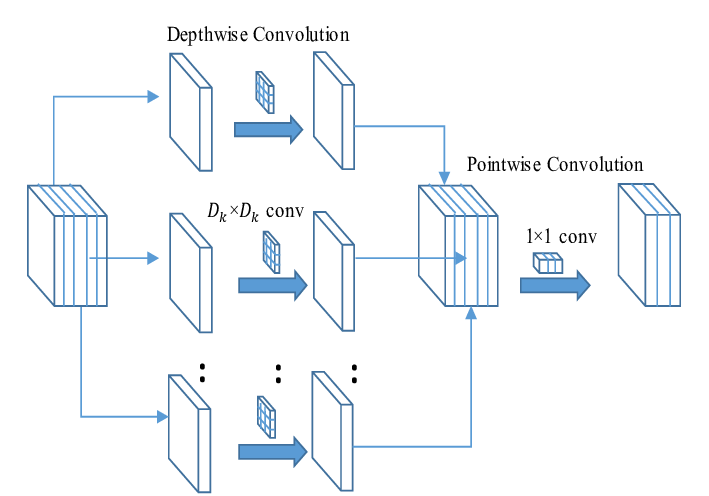
출처 : https://www.researchgate.net/figure/Depthwise-separable-convolution-block_fig1_343943234

### 작은 데이터셋에서 이미지 분류 문제를 위한 가벼운 깊이별 분리 컨브넷 예제

In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

height = 64
width = 64
channels = 3
num_classes = 10

model = Sequential()
model.add(layers.SeparableConv2D(32, 3,
                                 activation='relu',
                                 input_shape=(height, width, channels,)))
model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D(2))

model.add(layers.SeparableConv2D(64, 3, activation='relu'))
model.add(layers.SeparableConv2D(128, 3, activation='relu'))
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [2]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 62, 62, 32)        155       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 60, 60, 64)        2400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 28, 28, 64)        4736      
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 26, 26, 128)       8896      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 11, 11, 64)        9

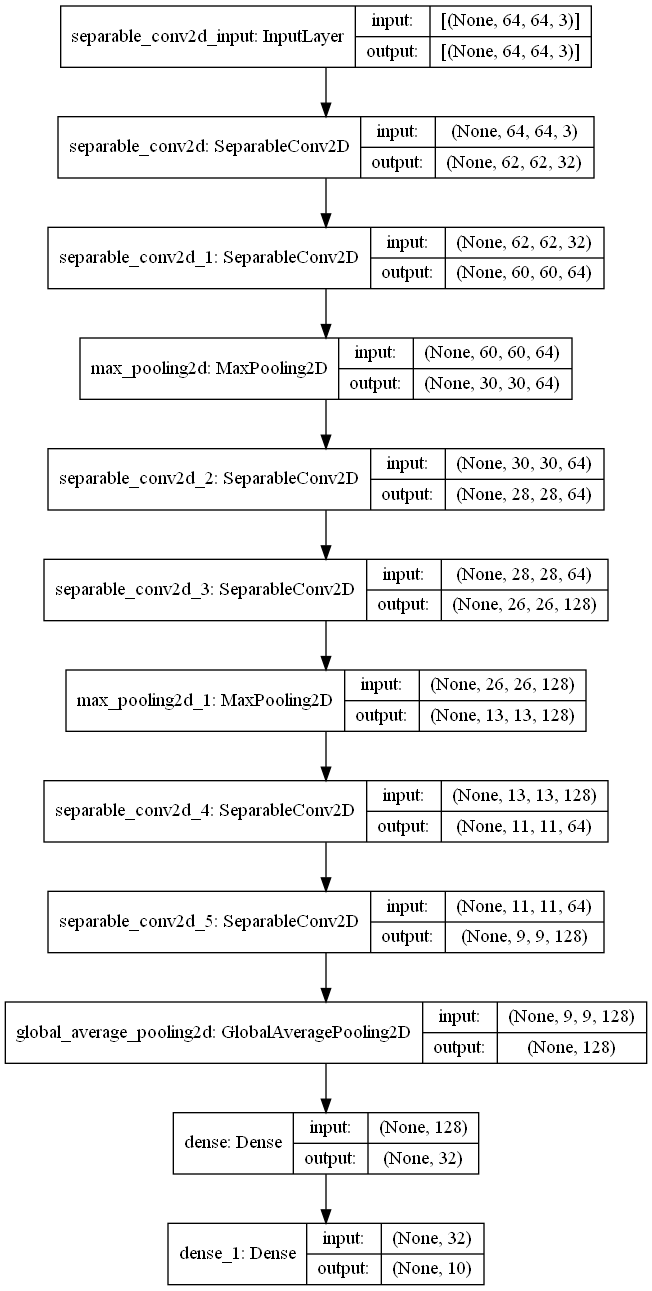

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## 7.3.2 하이퍼파라미터 최적화
- 딥러닝 모델을 만들 때 무작위로 보이는(**하이퍼파라미터**(hyperparameter)) 결정을 해야함
    - 얼마나 많은 층을 쌓을지
    - 층마다 얼마나 많은 유닛과 필터를 둘지
    - `relu` 활성화 함수를 쓸지, 다른 함수를 쓸지
    - 어떤 층 뒤에 `BatchNormalization`을 사용해야 할지
    - 드롭아웃은 얼마나 해야 할지 등
- 공식적인 규칙은 없으며, 최대의 성능을 얻으려면 임의로 선택한 결정에 만족하면 안 됨
- 가능한 결정 공간을 자동적, 조직적, 규칙적 방법으로 탐색해야 함
- 하이퍼파라미터 자동 최적화가 이에 관련된 분야로 중요한 분야 중 하나임
- 하이퍼파라미터 최적화 과정
   1. 일련의 하이퍼파라미터를 (자동으로) 선택
   2. 선택된 하이퍼파라미터로 모델을 학습, 검증 데이터에서 최종 성능을 측정
   3. 다음으로 시도할 하이퍼파라미터를 (자동으로) 선택
   4. 1~3 과정 반복
   5. 테스트 데이터에서 성능 측정
- 다음 번에 시도할 하이퍼파라미터를 선택하는 알고리즘 : 베이지안 최적화(bayesian optimization), 유전 알고리즘(genetic algorithms), 간단한 랜덤 탐색(random search) 등
- 하이퍼파라미터를 업데이트하는 것은 매우 어려운 일
    - 새로운 모델을 만들고 데이터셋을 사용하여 처음부터 다시 훈련해야 함
    - 하이퍼파라미터 공간은 연속적이지 않고 미분 가능하지 않기 때문에 경사 하강법을 사용할 수 없고, 비효율적인 그래디언트-프리(gradient-free) 최적화 기법을 사용해야 함
- 랜덤 탐색이 가장 좋을 방법일 때가 많음
    - `tensorflow.keras.wrappers.scikit_learn` 모듈 아래에 있는 `KerasClassifier`와 `KerasRegressor` 클래스를 이용하면 사이킷런의 `RandomizedSearchCV`를 사용하여 랜덤한 하이퍼파라미터 탐색 수행 가능
- 랜덤 탐색보다 더 나은 도구
    - Hyperopt 파이썬 라이브러리
        - https://github.com/hyperopt/hyperopt
        - 잘 작동할 것 같은 하이퍼파라미터 조합을 예측하기 위해 내부적으로 Parzen 트리 추정기(Parzen Tree Estimator;PTE)를 사용
    - Hyperas 파이썬 라이브러리
        - https://github.com/maxpumperla/hyperas
        - Hyperopt와 연동하여 케라스 모델에 사용할 수 있음
- 주의할 점 : 검증 세트의 과대적합

## 7.3.3 모델 앙상블
- **모델 앙상블**(model ensemble) : 여러 개 다른 모델의 예측을 합쳐서 더 좋은 예측을 만듦
- 모델 각자의 관점으로 데이터를 이해하고, 이 모델을 모으면 더 정확하게 데이터를 묘사할 수 있다는 가정
- 가장 쉬운 방법은 추론 예측을 평균내는 것

```python
# 4개의 다른 모델을 사용하여 초기 예측을 계산
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

# 새로운 예측은 어떤 초기 예측보다 더 정확해야 함
final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)
```

    - 이 방식은 분류기들이 어느 정도 비슷하게 좋을 때 잘 작동하며 분류기 중 하나가 다른 모델보다 월등히 나쁘면 최종 예측은 앙상블에 있는 가장 좋은 분류기만큼 좋지 않을 수 있음
- 검증 데이터에서 학습된 가중치를 사용하여 가중 평균하는 것이 더 좋은 방법
    - 분류기가 좋을수록 높은 가중치, 나쁜 분류기일수록 낮은 가중치
    - 랜덤 서치나 넬더-미드(Nelder-Mead) 방법(비선형 최적화 문제를 위한 방법으로 아메바 방법(amoeba method)이라고도 부름)을 사용

```python
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

# 가중치 (0.5, 0.25, 0.1, 0.15)는 경험적으로 학습되었다고 가정
final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d
```

- 예측의 지수 값을 평균하는 것도 하나의 방법
- 가능한 최대한 다르면서 좋은 모델을 앙상블하여야 함
    - 같은 네트워크를 랜덤 초기화를 다르게 하여 따로따로 여러 번 훈련해서 앙상블하는 것은 해 볼 가치가 없음
- 잘 작동하는 한 가지 방법은 트리 기반 모델(랜덤 포레스트, 그래디언트 부스팅 트리 등)이나 심층 신경망을 앙상블하는 것